<a href="https://colab.research.google.com/github/hqjeon/1st-assignment/blob/master/donchian_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### Indicators

In [3]:
def benchmark_indicator(ticker_data, long_window):
    daily_indicator = pd.Series(np.zeros(len(ticker_data.index)), index=ticker_data.index)
    daily_indicator.iloc[long_window:] = 1
    daily_indicator.iloc[-1] = -1
    return daily_indicator.values

In [4]:
def donchian_breakout_indicator(ticker_data, long_window, short_window):
    channel_upper = pd.Series(ticker_data['Close']).rolling(long_window).max()
    channel_lower = pd.Series(ticker_data['Close']).rolling(short_window).min()

    donchian_rising_edge_index = np.flatnonzero(
        (np.array(ticker_data['Close'][:-1]) < channel_upper[1:])
        & (np.array(ticker_data['Close'][1:]) > channel_upper[:-1])
    )
    donchian_falling_edge_index = np.flatnonzero(
        (np.array(ticker_data['Close'][:-1]) > channel_lower[1:])
        & (np.array(ticker_data['Close'][1:]) < channel_lower[:-1])
    )

    daily_indicator = pd.Series(np.zeros(len(ticker_data.index)), index=ticker_data.index)
    daily_indicator.iloc[donchian_rising_edge_index + 1] = 1
    daily_indicator.iloc[donchian_falling_edge_index + 1] = -1
    daily_indicator.iloc[-1] = -1
    return daily_indicator.values

In [34]:
def price_momentum_monthly_indicator(daily_data, lookback_month, holding_month):
    """
    월말에 12개월 전 대비 1개월 전 주가기 높거나 같다면 다음달 월초 첫 영업일 종가에 매수
    월말에 12개월 전 대비 1개월 전 주가가 낮다면 다음달 월초 첫 영업일 종가에 매도
    """
    # Extract close prices into a Series with a datetime index
    daily_close = pd.Series(daily_data.Close, daily_data.index)
    monthly_close = daily_close.groupby(daily_close.index.to_period('M')).last()

    # Calculate price momentum (compare with the price 12 months ago)
    monthly_indicator = monthly_close.shift(holding_month) >= monthly_close.shift(lookback_month)
    monthly_indicator.index = monthly_indicator.index.to_timestamp()

    # Convert monthly_indicator to align with daily data; forward-fill the monthly signals
    daily_indicator = monthly_indicator.reindex(daily_data.index.date, method='ffill')

    # As the initial 12 months do not have a comparison, set them to False
    daily_indicator[:len(daily_close) - len(daily_indicator)] = False
    daily_indicator.iloc[-1] = False
    daily_indicator = daily_indicator.astype(int)
    daily_indicator[daily_indicator == 0] -= 1
    return daily_indicator.values

In [6]:
def volatility_targeting_position(daily_data, signal_data=None, window=20, threshold=0.01):
    daily_close = pd.Series(daily_data.Close)
    volatility = daily_close.pct_change().rolling(window).std()
    size = 1 / (volatility / threshold)
    size = size.fillna(0)

    return size

### modularization

In [18]:
def fetch_data(ticker, start="2000-01-01", end=None):
    if end is None:
      data = yf.download(ticker, start=start, group_by='ticker')
    else:
      data = yf.download(ticker, start=start, end=end, group_by='ticker')
    data = data[ticker][['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# def plot_equity_curves(stats, labels, data, strategy_name='Momentum'):
#     plt.figure(figsize=(12, 8))
#     for stat, label in zip(stats, labels):
#         plt.plot(stat._equity_curve.index, stat._equity_curve['Equity'], label=label)

#         # Plot buy signals
#         buy_signals = stat._trades[(stat._trades['Size'] > 0) & (stat._trades['EntryBar'] < len(data))]
#         buy_dates = data.iloc[buy_signals['EntryBar']].index
#         plt.scatter(buy_dates, stat._equity_curve['Equity'][buy_signals['EntryBar']], color='green', marker='^', label='Buy Signal', alpha=0.7)

#         # Plot sell signals
#         sell_signals = stat._trades[(stat._trades['Size'] > 0) & (stat._trades['ExitBar'] < len(data))]
#         sell_dates = data.iloc[sell_signals['ExitBar']].index
#         plt.scatter(sell_dates, stat._equity_curve['Equity'][sell_signals['ExitBar']], color='red', marker='v', label='Sell Signal', alpha=0.7)

#     plt.title(f'Equity Curve and Trade Signals: {strategy_name} vs Buy & Hold')
#     plt.xlabel('Time')
#     plt.ylabel('Equity')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [8]:
def filter_gte(indicator, threshold_gte=1):
    filtered_indicator = np.zeros(len(indicator))
    filtered_indicator[1:] = (indicator[1:] >= threshold_gte) & (indicator[:-1] < threshold_gte)
    filtered_indicator[0] = indicator[0] >= threshold_gte
    return filtered_indicator

def filter_lte(indicator, threshold_lte=-1):
    filtered_indicator = np.zeros(len(indicator))
    filtered_indicator[1:] = (indicator[1:] <= threshold_lte) & (indicator[:-1] > threshold_lte)
    filtered_indicator[0] = indicator[0] <= threshold_lte
    return filtered_indicator

def set_signal(filtered_indicator):
    return np.where(filtered_indicator == 1)

In [9]:
def set_transactions(buy_signal, sell_signal):
    buy_queue = deque(*buy_signal)
    sell_queue = deque(*sell_signal)

    # Initialize transaction variables
    transactions = []
    last_sell_index = None
    pending_buy_index = None

    # Process buy and sell queues
    while buy_queue and sell_queue:
        # Get the next buy and sell indices
        if pending_buy_index is None:
            pending_buy_index = buy_queue.popleft()

        current_sell_index = sell_queue.popleft()

        # Skip invalid buys that come before the last valid sell
        while last_sell_index and pending_buy_index < last_sell_index:
            try:
                pending_buy_index = buy_queue.popleft()
            except IndexError:
                pending_buy_index = None
                break

        # If buy is valid (less than sell), record transaction
        if pending_buy_index and pending_buy_index < current_sell_index:
            transactions.append((pending_buy_index, current_sell_index))
            last_sell_index = current_sell_index
            pending_buy_index = None  # Reset to fetch the next buy
        else:
            # Otherwise, keep the buy pending and move to the next sell
            continue

    # Handle remaining unpaired buy
    # if pending_buy_index:
    #     transactions.append((pending_buy_index, None))

    return transactions

In [10]:
def set_backtest(ticker_data, transactions, position=None, commission=0.0025, leveraged=1):
    backtest_data = pd.DataFrame(index=ticker_data.index)
    backtest_data['position'] = np.zeros(len(ticker_data))
    backtest_data['change'] = np.zeros(len(ticker_data))
    for buy_index, sell_index in transactions:
        if position is not None:
            backtest_data['position'].iloc[buy_index:sell_index + 1] = position.iloc[buy_index:sell_index + 1]
        else:
            backtest_data['position'].iloc[buy_index:sell_index + 1] = leveraged
        backtest_data['change'].iloc[buy_index:sell_index + 1] = (ticker_data['Close'].iloc[buy_index:sell_index + 1].pct_change().fillna(0)) * backtest_data['position'].iloc[buy_index:sell_index + 1]
        backtest_data['change'].iloc[buy_index] -= commission
        backtest_data['change'].iloc[sell_index] -= commission
    backtest_data['performance'] = (backtest_data.change + 1).cumprod()
    return backtest_data

In [11]:
def set_statistics(backtest_data):
    statistics_data = {
        'Exposure Time (%)': sum(backtest_data.position) / len(backtest_data.index) * 100,
        'Equity Final (Unit)': backtest_data.performance.iloc[-1],
        'Equity Peak (Unit)': backtest_data.performance.max(),
        'Return (%)': (backtest_data.performance.iloc[-1] - 1) * 100,
        'Return (Ann.) (%)': (backtest_data.performance.iloc[-1] ** (1 / len(backtest_data.groupby(backtest_data.index.year))) - 1) * 100
    }
    return statistics_data

In [12]:
# bnh_indicator = benchmark_indicator(ticker_data, 20)
# strategy_indicator = donchian_breakout_indicator(ticker_data, 20, 20)

# bnh_buy_signal = set_signal(filter_gte(bnh_indicator, threshold_gte=1))
# bnh_sell_signal = set_signal(filter_lte(bnh_indicator, threshold_lte=-1))
# bnh_transactions = set_transactions(bnh_buy_signal, bnh_sell_signal)

# strategy_buy_signal = set_signal(filter_gte(strategy_indicator, threshold_gte=1))
# strategy_sell_signal = set_signal(filter_lte(strategy_indicator, threshold_lte=-1))
# strategy_transactions = set_transactions(strategy_buy_signal, strategy_sell_signal)

# bnh_data = set_backtest(ticker_data, bnh_transactions)
# backtest_data = set_backtest(ticker_data, strategy_transactions)

# backtest_data.performance.plot()
# bnh_data.performance.plot()

### Encapsulation

In [13]:
class Strategy():
    def __init__(self, ticker_data, indicator, position=None, commission=.0025, leveraged=1):
        self.ticker_data = ticker_data
        self.strategy_indicator = indicator
        self.strategy_buy_signal = None
        self.strategy_sell_signal = None
        self.strategy_transactions = None
        self.backtest_data = None
        self.statistics_data = None
        self.position = position
        self.commission = commission
        self.leveraged = leveraged

    def run_backtest(self):
        self.strategy_buy_signal = set_signal(filter_gte(self.strategy_indicator, threshold_gte=1))
        self.strategy_sell_signal = set_signal(filter_lte(self.strategy_indicator, threshold_lte=-1))
        self.strategy_transactions = set_transactions(self.strategy_buy_signal, self.strategy_sell_signal)
        self.backtest_data = set_backtest(
            self.ticker_data,
            self.strategy_transactions,
            position=self.position,
            commission=self.commission,
            leveraged=self.leveraged,
        )

    def get_output(self):
        self.backtest_data.performance.plot()
        self.statistics_data = set_statistics(self.backtest_data)
        return self.statistics_data

### Strategy Test

In [30]:
ticker_data = fetch_data('^IXIC', '2020-01-01', '2024-08-21')

[*********************100%***********************]  1 of 1 completed


<ipython-input-10-9df73783a75a>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  backtest_data['position'].iloc[buy_index:sell_index + 1] = leveraged
<ipython-input-10-9df73783a75a>:10: FutureWarning: ChainedAssignmentError: behaviour will c

{'Exposure Time (%)': 99.91423670668954,
 'Equity Final (Unit)': 1.9652222406370607,
 'Equity Peak (Unit)': 2.0620004237183567,
 'Return (%)': 96.52222406370608,
 'Return (Ann.) (%)': 14.467535917263685}

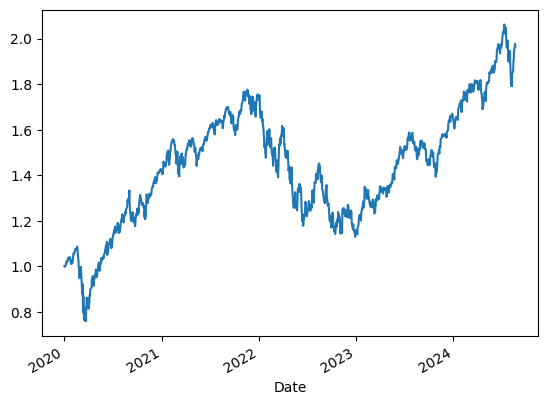

In [32]:
bnh_strategy = Strategy(ticker_data, benchmark_indicator(ticker_data, 1), leveraged=1)
bnh_strategy.run_backtest()
bnh_strategy.get_output()

<ipython-input-10-9df73783a75a>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  backtest_data['position'].iloc[buy_index:sell_index + 1] = leveraged
<ipython-input-10-9df73783a75a>:10: FutureWarning: ChainedAssignmentError: behaviour will c

{'Exposure Time (%)': 192.19554030874787,
 'Equity Final (Unit)': 3.0241252410959194,
 'Equity Peak (Unit)': 3.805420851938175,
 'Return (%)': 202.41252410959194,
 'Return (Ann.) (%)': 24.772809627243355}

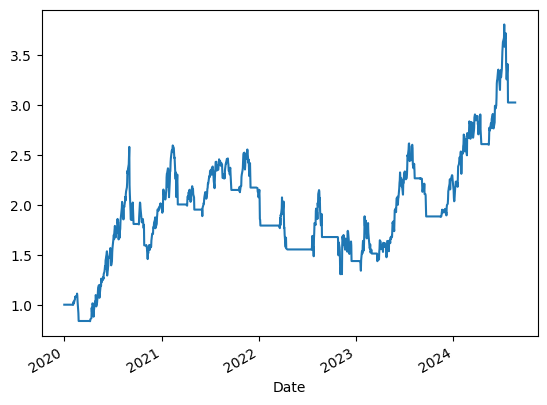

In [21]:
donchian_strategy = Strategy(ticker_data, donchian_breakout_indicator(ticker_data, 20, 20), leveraged=3)
donchian_strategy.run_backtest()
donchian_strategy.get_output()

<ipython-input-34-54499eeb2aa8>:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_close = daily_close.groupby(daily_close.index.to_period('M')).last()
<ipython-input-10-9df73783a75a>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

{'Exposure Time (%)': 56.946826758147516,
 'Equity Final (Unit)': 1.4259338290103825,
 'Equity Peak (Unit)': 1.4961545309301028,
 'Return (%)': 42.59338290103825,
 'Return (Ann.) (%)': 7.354406292936155}

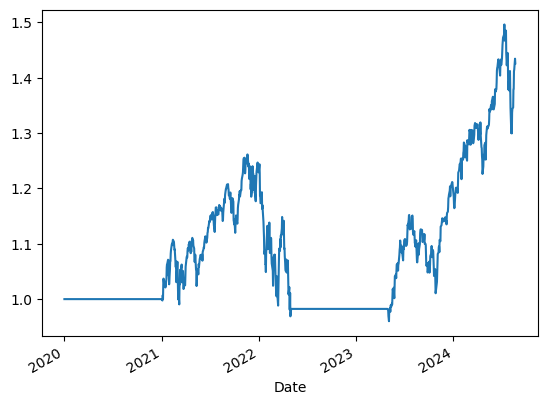

In [35]:
price_momentum_monthly_strategy = Strategy(ticker_data, price_momentum_monthly_indicator(ticker_data, 12, 1), leveraged=1)
price_momentum_monthly_strategy.run_backtest()
price_momentum_monthly_strategy.get_output()

<ipython-input-10-9df73783a75a>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  backtest_data['position'].iloc[buy_index:sell_index + 1] = position.iloc[buy_index:sell_index + 1]
<ipython-input-10-9df73783a75a>:10: FutureWarning: ChainedAss

{'Exposure Time (%)': 82.0642260275909,
 'Equity Final (Unit)': 2.110146105980689,
 'Equity Peak (Unit)': 2.233209141542294,
 'Return (%)': 111.0146105980689,
 'Return (Ann.) (%)': 16.10809654024323}

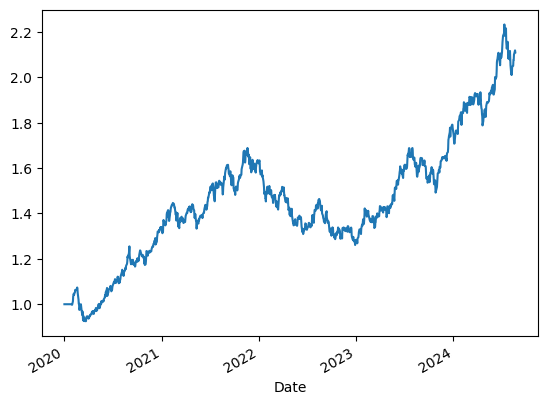

In [24]:
volatility_targeting_strategy = Strategy(
    ticker_data,
    benchmark_indicator(ticker_data, 20),
    position=volatility_targeting_position(ticker_data)
)
volatility_targeting_strategy.run_backtest()
volatility_targeting_strategy.get_output()

<Axes: xlabel='Date'>

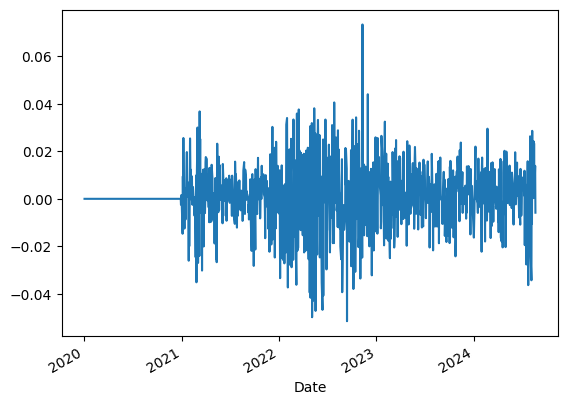

In [25]:
bnh_strategy.backtest_data.change.plot()

<Axes: xlabel='Date'>

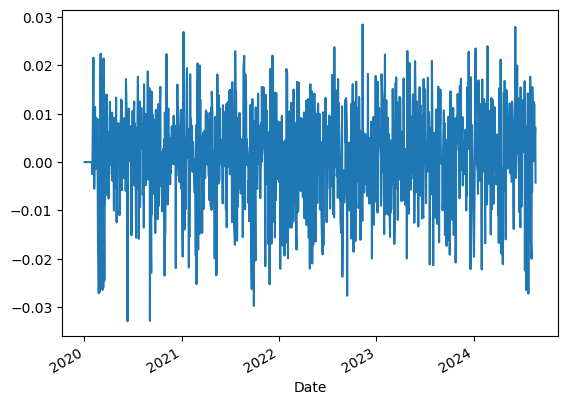

In [26]:
volatility_targeting_strategy.backtest_data.change.plot()

<Axes: xlabel='Date'>

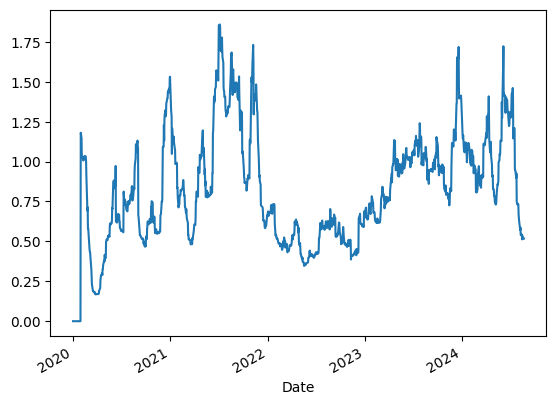

In [27]:
volatility_targeting_strategy.position.plot()

### plain script

In [ ]:
np.where(indicator == 1)

(array([ 20,  21,  53,  59,  60,  61,  80,  85,  86,  89,  94, 100, 101,
        104, 110, 111, 112, 113, 123, 124, 130, 131, 134, 135, 165, 166,
        219, 220, 221, 222, 230, 234, 235, 236, 237, 238, 239, 240, 241,
        242, 246, 247]),)

In [ ]:
np.where(indicator == -1)

(array([ 39,  45,  46, 150, 155, 156, 157, 180, 181, 188, 201, 204, 205]),)

In [ ]:
buy_indicator = np.zeros(len(indicator))
# buy_indicator[1:] = (indicator[1:] > 0.5) & (indicator[:-1] < 0.5)
buy_indicator[1:] = (indicator[1:] >= 1) & (indicator[:-1] < 1)
buy_indicator[0] = indicator[0] == 1
buy_signal = np.where(buy_indicator == 1)

In [ ]:
buy_signal

(array([ 20,  53,  59,  80,  85,  89,  94, 100, 104, 110, 123, 130, 134,
        165, 219, 230, 234, 246]),)

In [ ]:
sell_indicator = np.zeros(len(indicator))
# sell_indicator[1:] = (indicator[1:] < -0.5) & (indicator[:-1] > -0.5)
sell_indicator[1:] = (indicator[1:] <= -1) & (indicator[:-1] > -1)
sell_indicator[0] = indicator[0] == -1
sell_signal = np.where(sell_indicator == 1)

In [ ]:
sell_signal

(array([ 39,  45, 150, 155, 180, 188, 201, 204]),)

In [ ]:
buy_signal, sell_signal

((array([ 20,  53,  59,  80,  85,  89,  94, 100, 104, 110, 123, 130, 134,
         165, 219, 230, 234, 246]),),
 (array([ 39,  45, 150, 155, 180, 188, 201, 204]),))

In [ ]:
buy_queue = deque(*buy_signal)
sell_queue = deque(*sell_signal)

# Initialize transaction variables
transactions = []
last_sell_index = None
pending_buy_index = None

# Process buy and sell queues
while buy_queue and sell_queue:
    # Get the next buy and sell indices
    if pending_buy_index is None:
        pending_buy_index = buy_queue.popleft()

    current_sell_index = sell_queue.popleft()

    # Skip invalid buys that come before the last valid sell
    while last_sell_index and pending_buy_index < last_sell_index and buy_queue:
        pending_buy_index = buy_queue.popleft()

    # If buy is valid (less than sell), record transaction
    if pending_buy_index < current_sell_index:
        transactions.append((pending_buy_index, current_sell_index))
        last_sell_index = current_sell_index
        pending_buy_index = None  # Reset to fetch the next buy
    else:
        # Otherwise, keep the buy pending and move to the next sell
        continue

# Handle remaining unpaired buy
if pending_buy_index:
    transactions.append((pending_buy_index, None))

transactions

[(20, 39), (53, 150), (165, 180), (219, None)]

In [ ]:
backtest_data = pd.DataFrame(index=ticker_data.index)
backtest_data['position'] = np.zeros(len(ticker_data))
backtest_data['change'] = np.zeros(len(ticker_data))
for buy_index, sell_index in transactions:
    if sell_index:
        backtest_data['position'].iloc[buy_index:sell_index] = 1
        backtest_data['change'].iloc[buy_index:sell_index] = ticker_data['Close'].pct_change().fillna(1).iloc[buy_index:sell_index]
    else:
        backtest_data['position'].iloc[buy_index:] = 1
        backtest_data['change'].iloc[buy_index:] = ticker_data['Close'].pct_change().fillna(1).iloc[buy_index:]

<Axes: xlabel='Date'>

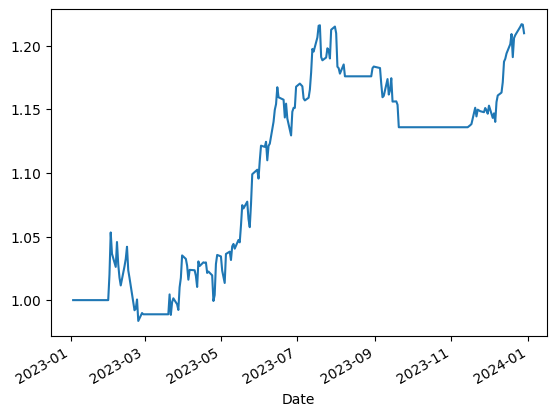

In [ ]:
(backtest_data.change + 1).cumprod().plot()

<Axes: xlabel='Date'>

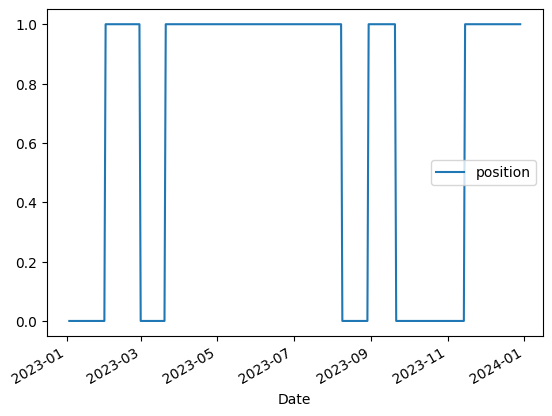

In [ ]:
backtest_data.position.plot()

In [ ]:
ticker_data['Close'].iloc[29:].pct_change().fillna(1)

,Close
Date,
2023-02-14,1.000000
2023-02-15,0.009234
2023-02-16,-0.017792
2023-02-17,-0.005783
2023-02-21,-0.025024
...,...
2023-12-22,0.001945
2023-12-26,0.005443
2023-12-27,0.001633


In [ ]:
ticker_data['Close'].iloc[29:] / ticker_data['Close'].iloc[29]

,Close
Date,
2023-02-14,1.000000
2023-02-15,1.009234
2023-02-16,0.991278
2023-02-17,0.985545
2023-02-21,0.960883
...,...
2023-12-22,1.253577
2023-12-26,1.260400
2023-12-27,1.262457


In [ ]:
ticker_data['Close'].pct_change()

,Close
Date,
2023-01-03,NaN
2023-01-04,0.006911
2023-01-05,-0.014679
2023-01-06,0.025623
2023-01-09,0.006279
...,...
2023-12-22,0.001945
2023-12-26,0.005443
2023-12-27,0.001633
